## Active Contours using Level Sets

Dans ce TP, nous allons nous intéresser à la segmentation d'image par la méthode "Level Set".
Le principe général des contours actifs est de faire évoluer une courbe dans une image afin de détecter des objets.
Le courbe peut être initialisée en prenant le bord de l'image, un contour autour de l'objet, ou bien encore un ensemble de petits cercles (cf exercice 7).
Cette approche de détection de contours a été introduite par Osher et Sethian. Leur raisonnement est de considérer la courbe originale comme une surface. Il s'agit ensuite d'imaginer que cette surface définit une surface de niveau dans un volume 3D. Afin de donner un exemple, si la surface est une ellipse alors le volume prendra la forme d'un cône. D'autres lignes de niveau seront alors des courbes représentant de plus petites ou plus grandes ellipses.
En appliquant un raisonnement inverse, c'est comme si nous considérons une volume 3D que nous "tranchons" à l'aide d'un plan à différents "niveaux". Les surfaces de niveau ainsi trouvées ont des frontières définissant différentes courbes fermées ou non.

In [170]:
from __future__ import division

import scipy as scp
import numpy as np
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Managing level set functions

Dans la partie "Active Contours using parametric curves", nous avons représenté une courbe comme : $f(p) : S^1 \rightarrow \mathbb{R}^2$, dépendante d'un paramètre $p$. Pour chacun des $p$, nous avions un point de la courbe.

Désormais, nous allons représenter une courbe de façon implicite. Ce sont tous les points, c'est à dire tous les plans, satisfaisant une certaine équation égale à 0.
$$ \gamma = \{(x,y) | \varphi(x,y) = 0\} $$

Une courbe fermée définit une forme. La courbe du contour correspond aux points où $\varphi(x,y) = 0$. A l'extérieur du contour, nous aurons alors $\varphi < 0$ et $\varphi > 0$ à l'intérieur par exemple.

On commence par définir une grille sur laquelle nous travaillerons ensuite.

In [171]:
#discrétisation de taille nxn du domaine [0,1]²
n = 200
Y,X = np.meshgrid(np.arange(1,n+1), np.arange(1,n+1))

On pose $\varphi_{1}$ la fonction qui à (x,y) associe la distance entre (x,y) et le cercle de centre c et de rayon r.

In [172]:
r = n/3. #rayon du cercle

In [173]:
c = np.array([r,r]) + 10 #centre du cercle

In [174]:
phi1 = np.sqrt((X-c[0])**2 + (Y-c[1])**2) - r

#### Exercise 1 Load a square shape $\varphi_{2}$ at a different position for the center.

Nous allons définir une nouvelle fonction $\varphi_{2}$ qui sera un carré dont le centre est différent de celui précédemment défini pour le cercle.

In [175]:
#nouvelle position du centre
c = - np.array([r,r]) - 10 + n 

#pour avoir un carré : on fonctionne avec les valeurs absolues
A = abs(X-c[0]) 
B = abs(Y-c[1])
phi2 = np.maximum(A,B) - r

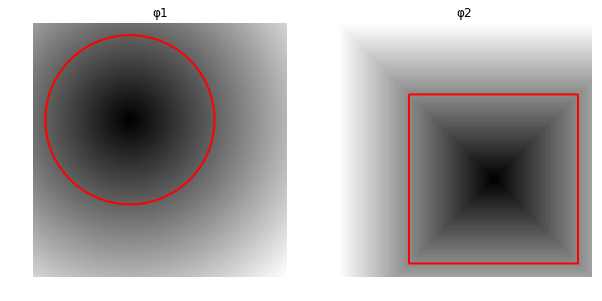

In [176]:
from nt_toolbox.plot_levelset import *
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.title("φ1")
plot_levelset(phi1)

plt.subplot(1,2,2)
plt.title("φ2")
plot_levelset(phi2)

#### Exercise 2 : Compute the intersection and the union of the two shapes. Store the union in $\varphi_{0}$ that we will use in the remaining part of the tour.

Nous allons maintenant calculer l'union et l'intersection des deux courbes précédentes (le cercle et le carré). Pour avoir l'union, on calcule la fonction minimum entre $\varphi_{1}$ et $\varphi_{2}$. Pour connaître l'intersection, il faut donc calculer la fonction maximum.

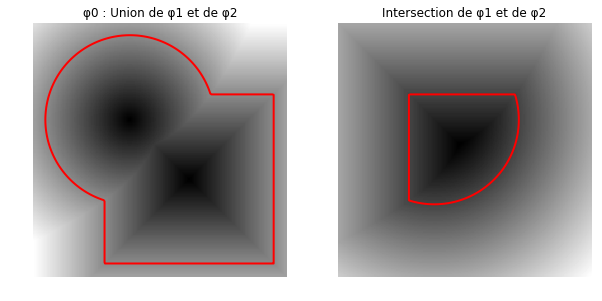

In [177]:
plt.clf
plt.figure(figsize = (10,5))

#définition de phi0 par l'union, ie: le minimum
phi0 = np.minimum(phi1,phi2)

#union, ie : min
plt.subplot(1,2,1)
plt.title("φ0 : Union de φ1 et de φ2")
plot_levelset(phi0)

#intersection, ie : max
plt.subplot(1,2,2)
plt.title("Intersection de φ1 et de φ2")
plot_levelset(np.maximum(phi1,phi2))

### Mean Curvature Motion

Comme dans le TP "Active contours using parametric curves", on utilise la notion de courbure moyenne. On doit minimiser le terme d'énergie suivant :

$$\underset{\varphi}{min} \int_{0}^{1}\| \varphi '(s)\| ds$$

On pose $\varphi_{t}$ une famille de courbes de niveaux paramétrées par un temps artificiel t, qui satisfait l'EDP suivante, aussi appelée équation du Mean Curvature Motion :

$$ \frac{\partial\varphi_{t}}{\partial t}=-G(\varphi_{t}) $$ avec $$ G(\varphi)=-\|\nabla\varphi\| div\left(\frac{\nabla\varphi}{\|\nabla\varphi\|}\right) $$


L'idée est de déterminer $\varphi$ par une descente de gradient :
$$ \varphi^{(l+1)}=\varphi^{(l)}-\tau G(\varphi^{(l)}) $$
avec $\tau>0$ et assez petit. 

In [178]:
#Temps max pour l'évolution
Tmax = 200 
#intervalle de temps
tau = .5 
#nombre maximal d'itérations
niter = int(Tmax/tau) 

In [179]:
#initialisation de φ à l'instant 0 de la descente de gradient
phi = np.copy(phi0) 

Tous les éléments de l'équation précédente ont besoin d'être déterminés. Pour commencer, on calcule le gradient $\nabla\varphi$ en utilisant la méthode des différences finies :

In [180]:
from nt_toolbox.grad import *
#calcul du gradient
#order = 2 : utilisation du schéma centré
g0 = grad(phi, order=2) 

On passe au calcul de la norme du gradient $\|\nabla\varphi\|$ :

In [181]:
#donne le plus petit float tel que 1. + eps soit différent de 1.
eps = np.finfo(float).eps 
#norme du gradient
norm = np.sqrt(np.sum(g0**2, 2))
#max entre un float très petit et la norme du gradient : on obtient toujours la norme du gradient car dans notre cas,
# ses composantes sont plus grandes que eps. Cette commande peut servir à éviter qu'une des composantes du gradient 
# soit nulle.
d = np.maximum(eps*np.ones([n,n]),norm)

On calcule le gradient normalisé ce qui nous permet de connaître l'amplitude de la direction à choisir :

In [182]:
g = g0/np.repeat(d[:,:,np.newaxis], 2, 2)

Puis le terme de courbure $G$ :

In [183]:
from nt_toolbox.div import *
G = -1 * d * div(g[:,:,0], g[:,:,1], order=2)

On peut à présent effectuer la première étape de la descente du gradient :

In [184]:
phi = phi - tau*G

#### Exercise 3 Implement the mean curvature motion.

Nous allons maintenant implémenter la méthode vue précédemment. Pour cela, à chaque itération, on calcule le gradient de $\varphi$ ainsi que sa norme pour obtenir le gradient normalisé. A partir de ce dernier, le terme de courbure peut être calculé et on applique la descente du gradient. 

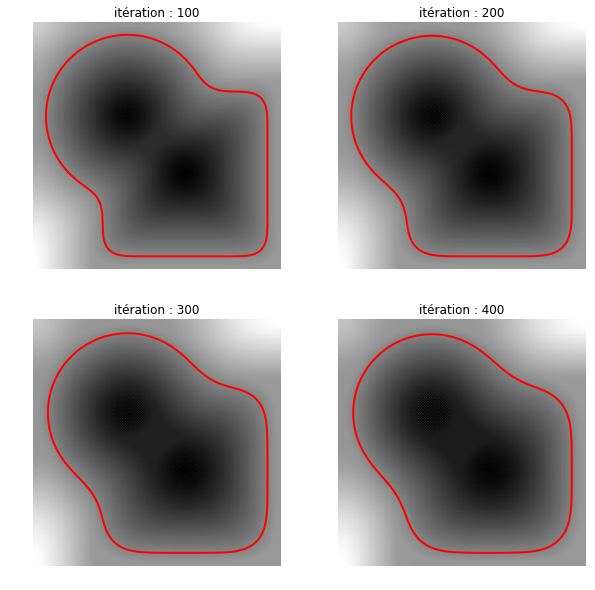

In [185]:
#pour avoir 4 sous-figures, on sépare les itérations en 4 sous-ensembles.
aff = np.arange(int(niter/4.),niter+1,int(niter/4.))

#initialisation
phi = np.copy(phi0)

plt.figure(figsize = (10,10))

k = 0
#algorithme du mean curvature motion tel que décrit précédemment
for i in range(1,niter+1):
    g0 = grad(phi, order=2)
    d = np.maximum(eps*np.ones([n,n]), np.sqrt(np.sum(g0**2, 2)))
    g = g0/np.repeat(d[:,:,np.newaxis], 2, 2)
    G = -1 * d * div(g[:,:,0], g[:,:,1], order=2)
    phi = phi - tau*G
    if i==aff[k]:
        #affichage de l'évolution de l'algorithme
        k = k+1 
        plt.subplot(2,2,k)
        plt.title("itération : "+str(i))
        plot_levelset(phi)


### Levelset Re-distancing

Un des problèmes rencontrés pendant la résolution de l'EDP peut être d'avoir une fonction de surface de niveau $\varphi$ de moins bonne qualité. Dans ce cas, le passage à la valeur zéro n'est pas détecté. Pour remédier à cette situation, on calcule la fonction distance signée, c'est à dire la fonction qui calcule la distance entre un point à la frontière de l'ensemble.
Tout d'abord, on extrait la fonction de surface de niveau :
$$C={(x,y) \in R, \varphi(x,y)=0}$$
On résout ensuite l'EDP suivante : 
$$\| \nabla \tilde{\varphi}(x)\|=1$$ et $$\forall y \in C,\tilde{\varphi}(y)=0 $$

Pour obtenir la fonction distance signée, on prend alors sign($\varphi(x)$)$\tilde{\varphi}(x)$.
On choisit $\varphi=\varphi_{0}^3$ pour que $\varphi$ ne soit pas la fonction distance signée. 

In [186]:
phi = phi0**3

In [187]:
from nt_toolbox.perform_redistancing import *
# on utilise une fonction déjà existante pour le redistancing. Cette fonction calcule la fonction distance signée associée
# à phi0 en gardant la même fonction de surface de niveau.
phi1 = perform_redistancing(phi0)

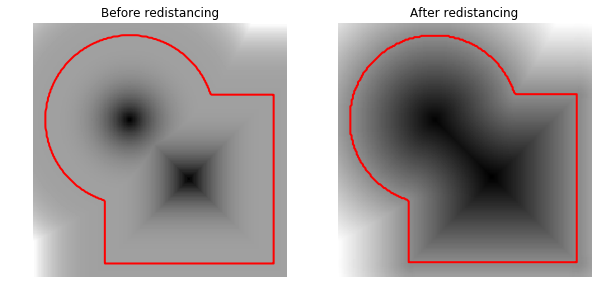

In [188]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plot_levelset(phi)
plt.title("Before redistancing")

plt.subplot(1,2,2)
plot_levelset(phi1)
plt.title("After redistancing")

plt.show()

Pour rappel, phi0 représente l'union d'un cercle et d'un carré. A gauche, on trace $\varphi$ qui est le cube de phi0 et à droite, on trace phi1 qui est la fonction distance signée de $\varphi$. 

### Edge-based Segmentation with Geodesic Active Contour

Nous allons utiliser les contours actifs géodésiques. Un contour actif géodésique se déforme dans le temps et l'espace pour permettre d'arriver jusqu'aux frontières de l'image.

In [189]:
# Taille $n$ de l'image et téléchargement de l'image.
n = 200
f0 = rescale(load_image("nt_toolbox/data/cortex.bmp", n))

Soit $f_{0}$ une image à segmenter. Pour utiliser la méthode des contours actifs géodésiques, il nous faut une fonction d'arrêt par rapport aux bords. Cette fonction doit être minimale dans les endroits où le gradient sera élevé et inversement. En effet, si le gradient de l'image est élevé, alors le changement d'intensité est plus grand.
On choisit comme fonction d'arrêt : 
$$W(x)=\alpha + \frac{\beta}{\epsilon+d(x)}$$ 
avec $d(x)=\| \nabla f_{0}\| \star h_{a}$. 
On a $d_{0}(x)=\| \nabla f_{0}\|$ qui correspond à la magnitude du gradient. 
D'un autre côté, $h_{a}$ est la matrice de convolution floue de taille a.


In [190]:
#Calcul du gradient et sa magnitude.
g = grad(f0, order=2) #calcul du gradient
d0 = np.sqrt(np.sum(g**2, 2)) #magnitude

In [191]:
a = 5 #coefficient de floutage

In [192]:
from nt_toolbox.perform_blurring import *
d = perform_blurring(d0, np.asarray([a]),bound="per") #floutage

In [193]:
epsilon = 1e-1

In [194]:
W = 1./(epsilon + d)
W = rescale(-d, 0.1, 1) #redimensionnement

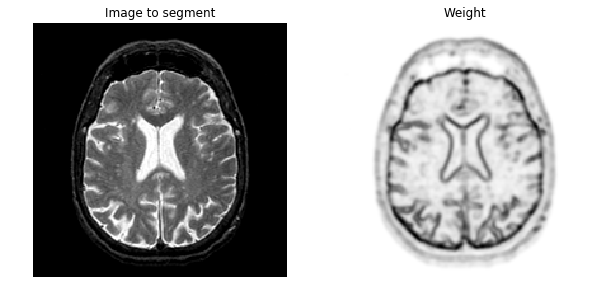

In [195]:
plt.figure(figsize=(10,5))
imageplot(f0, "Image to segment", [1,2,1])
imageplot(W, "Weight", [1,2,2])

On peut voir que l'image de droite est le résultat d'une image floutée de celle initiale. De plus, les frontières du cerveau sont en noirs alors que le reste de l'image est en niveau de gris. Nous allons donc pouvoir utiliser cette fonction d'arrêt W pour détecter le contour de l'image.

#### Exercise 4 Compute an initial shape φ0 at time t=0, for instance a centered square.

On reprend les données du début de fichier puis on initialise la forme $φ_{0}$ comme étant un carré centré.

In [196]:
#Données exo 1
Y,X = np.meshgrid(np.arange(1,n+1), np.arange(1,n+1))
r = n/3
c = np.array([r,r])/2 + r

#Forme initiale
phi0 = np.maximum(abs(X-c[0]),abs(Y-c[1])) - r

Affichage.

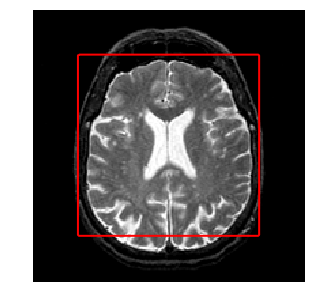

In [197]:
plt.figure(figsize=(5,5))
plot_levelset(phi0, 0, f0)

La méthode des contours actifs géodésiques consiste à minimiser la même fonction que pour mean curvature motion, en y impliquant le poids W. 
$$\underset{\varphi}{min} \int_{0}^{1}\| \varphi '(s)\|W(\varphi(s)) ds$$

L'implémentation des fonctions de surfaces de niveau sont solutions de la même EDP.

$$ \frac{\partial\varphi_{t}}{\partial t}=-G(\varphi_{t}) $$ 
avec 
$$ G(\varphi)=-\|\nabla\varphi\| div\left(W\frac{\nabla\varphi}{\|\nabla\varphi\|}\right) $$

Encore une fois, on détermine $\varphi$ par une descente de gradient :
$$ \varphi^{(l+1)}=\varphi^{(l)}-\tau G(\varphi^{(l)}) $$
avec $\tau>0$ et assez petit. 


In [198]:
tau = .4 #pas
Tmax = 1500 #temps max
niter = int(Tmax/tau) #nombre d'itérations
phi = np.copy(phi0) #copie de phi0 dans phi

In [199]:
gW = grad(W, order=2) #gradient de W, ordre 2

#### Exercise 5 Compute and store in G the gradient G(φ)(right hand side of the PDE) using the current value of the distance function φ.

Pour déterminer G($\varphi$), on utilise les mêmes formules qu'à l'exercice 3 en y ajoutant simplement le poids W.

In [200]:
gD = grad(phi, order=2)
d = np.maximum(eps*np.ones([n,n]), np.sqrt(np.sum(gD**2, 2)))
#Normalisation
g = gD/np.repeat(d[:,:,np.newaxis], 2, 2)

#Gradient
G = -1 * W * d * div(g[:,:,0], g[:,:,1], order=2) - np.sum(gW*gD,2)

In [201]:
phi = phi - tau*G  # on fait la méthode de descente de gradient

In [202]:
phi = perform_redistancing(phi)

#### Exercise 6 Implement the geodesic active contours gradient descent. Do not forget to do the re-distancing.


On implémente la méthode des contours actifs géodésiques. A chaque itération, on calcule la courbure G. Toutes les 30 itérations, on remplace phi par sa fonction distance signée. 

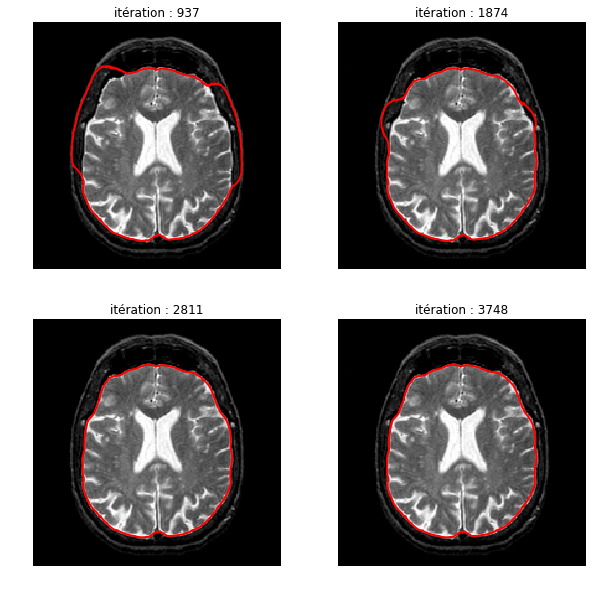

In [203]:
plt.figure(figsize=(10,10))

#Initialisation évolution
phi = phi0

k = 0
gW = grad(W,order=2)
for i in range(1,niter+1):
    gD = grad(phi,order=2)
    d = np.maximum(eps, np.sqrt(np.sum(gD**2,2)))
    g = gD/np.repeat(d[:,:,np.newaxis], 2, 2)
    G = W * d * div(g[:,:,0], g[:,:,1],order=2) + np.sum(gW*gD,2)
    phi = phi + tau*G
    if i%30==0 :
        phi = perform_redistancing(phi)
    if i % int(niter/4.) == 0:
        k = k+1
        plt.subplot(2,2,k)
        plt.title("itération : "+str(i))
        plot_levelset(phi,0,f0)

Plus le nombre d'itérations augmente, plus la détection du contour de cerveau devient précise. 

### Region-based Segmentation with Chan-Vese

Nous nous intéressons maintenant à une autre forme de segmentation. Elle se base sur une énergie à minimiser qui ressemble à une fonction constante par morceaux. 
$$\underset{\varphi}{min} L(\varphi) +\lambda \int_{\varphi(x)>0}|f_{0}(x)-c_{1}|^{2} dx +  \lambda \int_{\varphi(x)<0}|f_{0}(x)-c_{2}|^{2} dx$$
avec L la longueur de la fonction $\varphi$ de niveau 0. On a $(c_{1},c{2}) \in \mathbb{R}^{2}$.

#### Exercise 7 Compute an initial level set function φ0, stored in phi0, for instance many small circles.

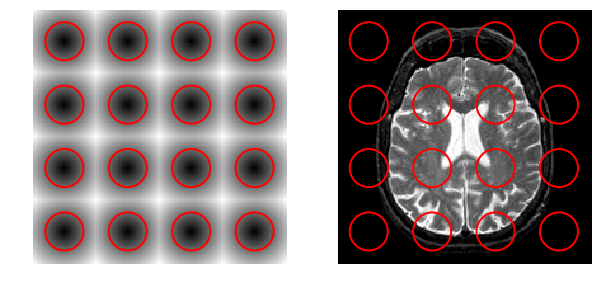

In [204]:
plt.figure(figsize=(10,10))

Y,X = np.meshgrid(np.arange(1,n+1), np.arange(1,n+1))
k = 4
r = .3*n/k #rayon
phi0 = np.zeros([n,n]) + np.float("inf")
for i in range(1,k+1):
    for j in range(1,k+1):
        c = (np.asarray([i,j])- 1)*(n/k) + (n/k)*.5
        phi0 = np.minimum(phi0, np.sqrt( abs(X-c[0])**2 + abs(Y-c[1])**2 ) - r )

plt.clf
plt.subplot(1,2,1)
plot_levelset(phi0)
plt.subplot(1,2,2)
plot_levelset(phi0,0,f0)

On vient de construire différents phi0 pour une même image. On introduit maintenant les paramètres qui interviennent dans l'équation de Chan-Vese.

In [219]:
lambd = 2
c1 = .7
c2 = 0
tau = .5
Tmax = 100
niter = int(Tmax/ tau)

In [215]:
phi = np.copy(phi0) #valeur initiale de phi

Encore une fois, le minimum qui correspond à l'équation de CV est solution de :
$$ \frac{\partial\varphi_{t}}{\partial t}=-G(\varphi_{t}) $$ 
avec 
$$ G(\varphi) = W \|{\nabla \varphi}\| \text{div}({ \frac{\nabla \varphi}{\|{\nabla \varphi}\|} )} + \lambda(f_0-c_1)^2 - \lambda (f_0-c_2)^2 $$ 


#### Exercise 8 Compute this gradient G(φ) using the current value of the distance function.

In [216]:
gD = grad(phi,order = 2)
d = np.maximum(eps * np.ones([n,n]), np.sqrt(np.sum(gD**2,2)))
g = gD/np.repeat(d[:,:,np.newaxis], 2, 2)
#gradient
G = W* d *div( g[:,:,0],g[:,:,1],order=2) - lambd*(f0-c1)**2 + lambd*(f0-c2)**2;

In [217]:
# on réalise une descente de gradient
phi = phi + tau*G

#### Exercise 9 Implement the full gradient descent.


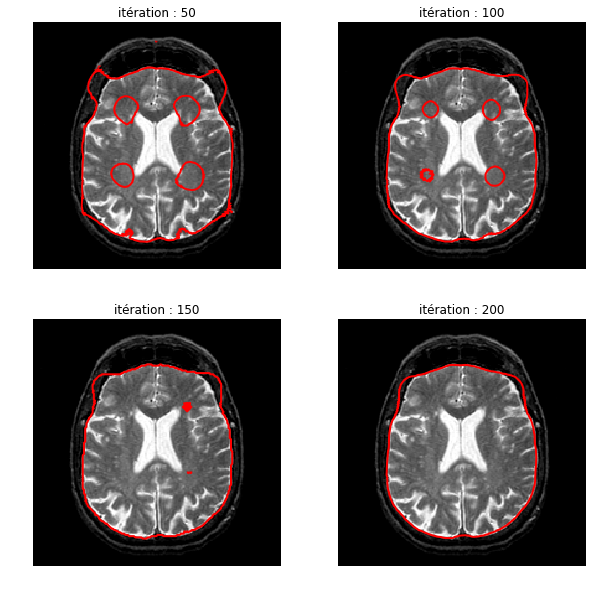

In [220]:
plt.figure(figsize=(10,10))

#intialisation
phi = np.copy(phi0)

k = 0
plt.clf
for i in range(1,niter+1):
    gD = grad(phi,order=2)
    d = np.maximum(eps*np.ones([n,n]), np.sqrt(np.sum(gD**2,2)) )
    g = gD/np.repeat(d[:,:,np.newaxis], 2, 2)
    G = W * d * div(g[:,:,0],g[:,:,1],order=2 ) - lambd*(f0-c1)**2 + lambd*(f0-c2)**2
    phi = phi + tau*G
    if i%30==0 :
        phi = perform_redistancing(phi)
    if i % int(niter/4)==0 :
        k = k+1
        plt.subplot(2,2,k)
        plt.title("itération : "+str(i))
        plot_levelset(phi,0,f0)

On implémente la descente de gradient en entier, en partant de l'équation de CV. Les résultats sont meilleurs puisque nous nous arrêtons à l'itération 200. Quand on augmente le nombre d'itérations, on s'aperçoit que le contour est trouvé plus rapidement que dans la partie des contours actifs géodésiques. En effet, au lieu d'une seule courbe de départ, on en utilise plusieurs, ce qui permet de converger plus rapidement.

Pour conclure sur les deux méthodes de détection de contour, nous pouvons dire que chacune présente à la fois des avantages et des inconvénients. Les méthodes paramétriques ne nécessitent pas énormément de points et sont alors particulièrement rapides. Cependant, elles sont sensibles au bruit et, par comparaison aux méthodes implicites, elles ne gèrent pas automatiquement les changements de topologie des courbes. Ceci signifie qu'une courbe peut se diviser, ou bien deux courbes peuvent fusionner automatiquement. En plus de cet avantage, les implémentations Level Sets donnent des résultats précis. Nous avons pu observer ce phénomène notamment avec la détection du cerveau. Le contour a été déterminé plus précisémment grâce à la méthode Level Sets. Les seuls inconvénients que nous avons pu imaginer pour cette dernière méthode sont le temps de calcul ainsi que le nombre de points utilisés (nettement supérieur par rapport aux méthodes paramétriques).

#### Références

* *An Analysis of Flame Propagation*, Sethian, J.A., Ph.D. Dissertation, Dept. of Mathematics, University of California, Berkeley, CA, 1982.

* *Curvature and the Evolution of Fronts*, Sethian, J.A., Comm. in Math. Phys., 101, pp. 487--499, 1985.

* *Numerical Methods for Propagating Fronts*, Sethian, J.A., in Variational Methods for Free Surface Interfaces, Proceedings of the Sept, 1985 Vallambrosa Conference, Eds. P. Concus and R. Finn, Springer-Verlag, NY, 1987.

* *Fronts Propagating with Curvature-Dependent Speed: Algorithms Based on Hamilton--Jacobi Formulations*, Osher, S., and Sethian, J.A., Journal of Computational Physics, 79, pp. 12--49, 1988. 